In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid

import matplotlib.pyplot as plt

In [32]:
import xbudget
import regionate
import xwmb

### Load grids and data

In [33]:
gridname = 'natv' #   choose from ['natv', 'rho2', 'zstr']
dt = 'daily' #       choose from ['monthly', 'daily', 'hourly']

In [34]:
# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_' 
time = "190*"
#time = "1900_02_01"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
snap = xr.open_mfdataset(rootdir+filename)

# Align N+1 snapshots so they bound N averages, and select year-long subset
ds = ds.sel(time=slice(snap.time[0], snap.time[-1]))
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))
snap = snap.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming to match hdrake conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', "salt":'so'})
snap = snap.rename({'temp':'thetao', "salt":'so'})

# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds, snap])

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    'xq': xr.DataArray(ocean_grid['xq'].values, dims=('xq',)),
    'yq': xr.DataArray(ocean_grid['yq'].values, dims=('yq',)),
    'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=('yh','xh')),
    'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=('yh','xh')),
    'geolon_u': xr.DataArray(ocean_grid['geolon_u'].values, dims=('yh','xq')),
    'geolat_u': xr.DataArray(ocean_grid['geolat_u'].values, dims=('yh','xq')),
    'geolon_v': xr.DataArray(ocean_grid['geolon_v'].values, dims=('yq','xh')),
    'geolat_v': xr.DataArray(ocean_grid['geolat_v'].values, dims=('yq','xh')),
    'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=('yq','xq')),
    'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=('yq','xq')),
    'dxt': xr.DataArray(ocean_grid['dxt'].values, dims=('yh', 'xh',)),
    'dyt': xr.DataArray(ocean_grid['dyt'].values, dims=('yh', 'xh',)),
    'dxCv': xr.DataArray(ocean_grid['dxCv'].values, dims=('yq', 'xh',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].values, dims=('yh', 'xq',)),
    'dxCu': xr.DataArray(ocean_grid['dxCu'].values, dims=('yh', 'xq',)),
    'dyCv': xr.DataArray(ocean_grid['dyCv'].values, dims=('yq', 'xh',)),
    'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=('yh', 'xh',)),
})
ds['lon'] = ds.geolon
ds['lat'] = ds.geolat

ds['sigma2_bounds'] = ds['rhopot2_bounds'] - 1000.
ds['sigma2'] = ds['rhopot2'] - 1000.

# z-coordinate dataset containing basic state variables
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'},
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

# Part 1. Water mass budgets within a fixed sub-region

### Collecting high-level budget terms

In [35]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(ds, budgets_dict)

### Specifying the horizontal boundaries of our water mass

In [127]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([15.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

### Instantiating the core `WaterMassBudget` class

In [128]:
wmb = xwmb.WaterMassBudget(
    grid,
    budgets_dict,
    region
)

### Computing water mass budgets

In [38]:
import warnings
import os

def fpath(lam):
    return f"/work/hfd/codedev/xwmb/data/budget_{name}_{lam}_{dt}_{gridname}_updated.nc"

wmts = {}
for lam in ["heat", "salt", "sigma2"]:
    if os.path.isfile(fpath(lam)):
        print("Loading pre-computed WMT.")
        wmts[lam] = xr.open_dataset(fpath(lam))

    else:
        print("Computing WMT...")
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            wmb.mass_budget(lam)
            wmb.wmt.load()
            wmb.wmt.to_netcdf(fpath(lam), mode="w")
            wmts[lam] = wmb.wmt

Computing WMT...
Computing WMT...
Process 'frazil_ice' for component salt is unavailable.
Process 'bottom_flux' for component salt is unavailable.
Computing WMT...


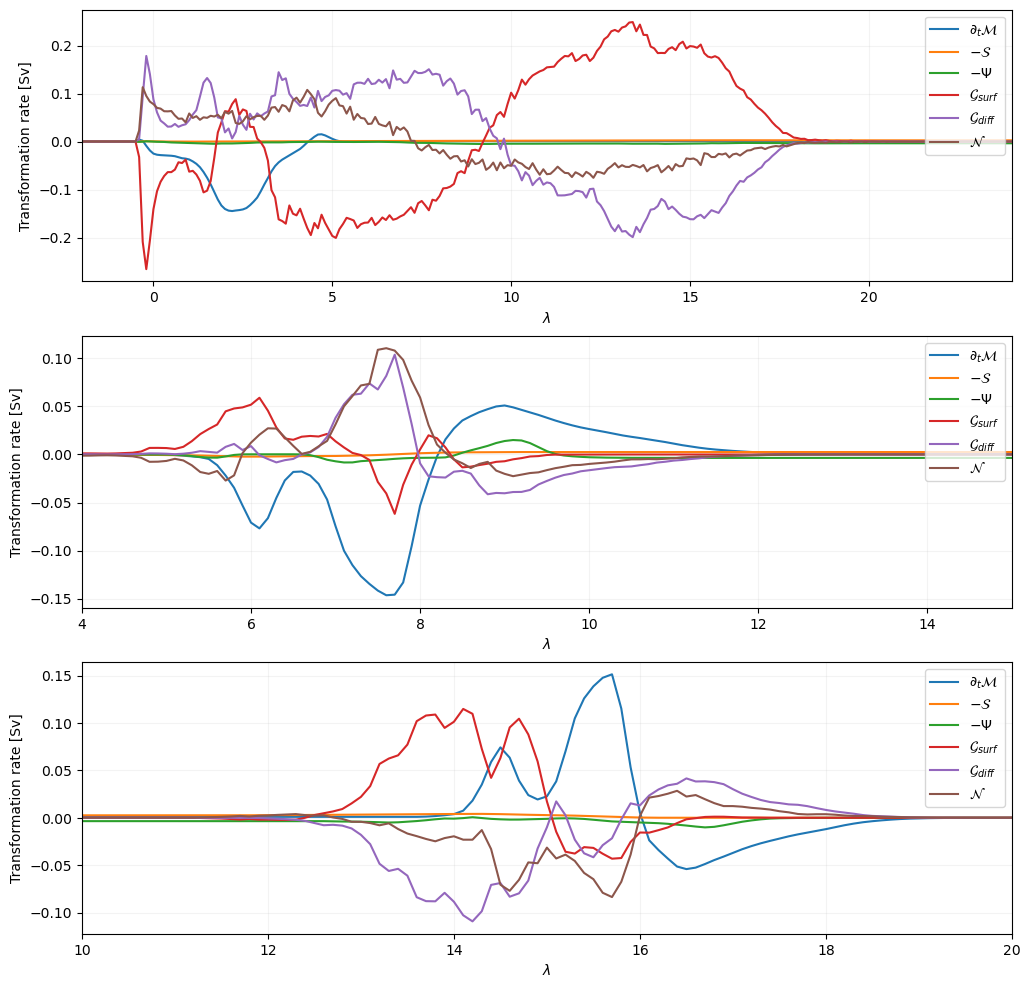

In [43]:
toSv = 1.e-6/wmb.rho_ref

plt.figure(figsize=(12, 12))
for i, (lam, xlims) in enumerate(zip(["heat", "salt", "sigma2"], [[-2, 24], [4, 15], [10, 20]])):
    wmt = wmts[lam]
    plt.subplot(3,1,i+1)
    
    boundary_fluxes = [
        'surface_exchange_flux',
        'surface_ocean_flux_advective_negative_lhs',
        'bottom_flux',
        'frazil_ice'
    ]
    
    wmt['boundary_fluxes'] = sum([wmt[term] for term in boundary_fluxes if term in wmt])
    
    (wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{M}$")
    (-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$")
    (-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$")
    (wmt['boundary_fluxes']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$")
    (wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$")
    (wmt['numerical_mixing']*toSv).mean('time').plot(label=r"$\mathcal{N}$")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.15)
    plt.ylabel("Transformation rate [Sv]")
    plt.xlabel(r"$\lambda$");
    plt.xlim(xlims);

# Part 2. Global water mass budgets

### Minimal diagnostics for closing the mass budget and estimating physical and numerical mixing globally


In [124]:
region = xr.ones_like(grid._ds['deptho'])

When the region is taken to be the whole domain, the horizontal cross-boundary fluxes vanish either because there is no flow through land or because of lateral boundary conditions of no-normal flow or periodicity (e.g. at the zonal boundaries and tripolar grid fold). Rather than having to put in all of the effort to compute this vanishing term explicitly (and saving the required mass transport diagnostics), we can simply use the `assert_zero_transport` flag when instantiating the `WaterMassBudget` class.

**Note:** This probably needs to be revisiting for a regional domain, where there may be imposed normal flow at the boundaries... If that is the case, then the overturning would need to be included in the calculation.

Also, instead of working from the full MOM6 budget provided by `xbudget`, we here include the bare minimum budget information necessary to close the global water mass budget (and thereby diagnose numerical mixing). For closing the heat budget, for example, we only need 6 three-dimensional tendency diagnostics plus the snapshots of thickness to get the mass tendency.

In [125]:
budgets_dict_minimal = xbudget.load_yaml("MOM6_num_mixing.yaml")
budgets_dict_minimal

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'rhs': {'var': None,
   'sum': {'var': None,
    'surface_exchange_flux': {'var': None,
     'product': {'var': None,
      'thickness_tendency': 'boundary_forcing_h_tendency',
      'density': 1035.0}}}}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'rhs': {'var': None,
   'sum': {'var': None,
    'diffusion': {'var': None,
     'sum': {'var': None,
      'lateral': 'opottemppmdiff',
      'interfacial': 'opottempdiff'}},
    'surface_exchange_flux': 'boundary_forcing_heat_tendency',
    'surface_ocean_flux_advective_negative_rhs': {'var': None,
     'product': {'var': None,
      'sign': -1.0,
      'specific_heat_capacity': 3992.0,
      'lambda_mass': 'tos',
      'thickness_tendency': 'boundary_forcing_h_tendency',
      'density': 1035.0}},
    'bottom_flux': 'internal_heat_heat_tendency',
    'frazil_ice': 'frazil_heat_tendency'}}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'rhs': {'var': Non

In [118]:
xbudget.collect_budgets(ds, budgets_dict_minimal)

wmb_min = xwmb.WaterMassBudget(
    grid,
    budgets_dict_minimal,
    region,
    assert_zero_transport=True
)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_min.mass_budget("heat")
    wmb_min.wmt.load()
    wmt_min = wmb_min.wmt

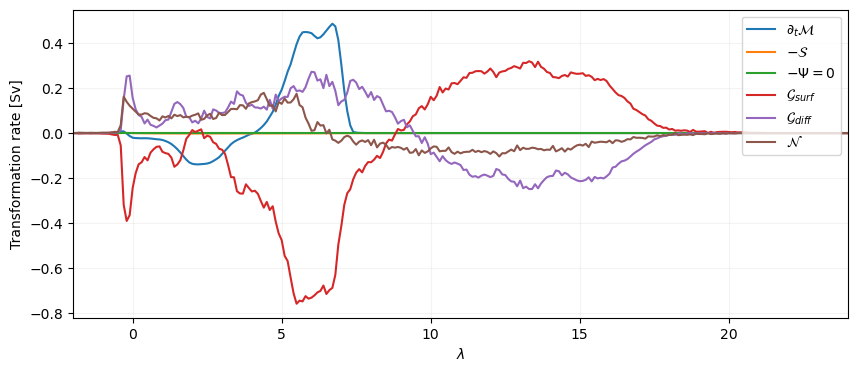

In [126]:
toSv = 1.e-6/wmb.rho_ref

plt.figure(figsize=(10, 4))
xlims = [-2, 24]
plt.subplot()

boundary_fluxes = [
    'surface_exchange_flux',
    'surface_ocean_flux_advective_negative_lhs',
    'bottom_flux',
    'frazil_ice'
]

wmt_min['boundary_fluxes'] = sum([wmt_min[term] for term in boundary_fluxes if term in wmt_min])

(wmt_min['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{M}$")
(-wmt_min['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$")
(-wmt_min['overturning']*toSv).mean('time').plot(label=r"$-\Psi = 0$")
(wmt_min['boundary_fluxes']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$")
(wmt_min['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$")
(wmt_min['numerical_mixing']*toSv).mean('time').plot(label=r"$\mathcal{N}$")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"$\lambda$");
plt.xlim(xlims);